**Part 1: Dataset Preparation and Fine-Tuning**

Step 1: Download the IMDB Dataset 

Dataset Shape: (50000, 2)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
None

First few rows of the dataset:
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

Missing values in each column:
review       0
sentiment    0
dtype: int64

Sentiment distribution:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64


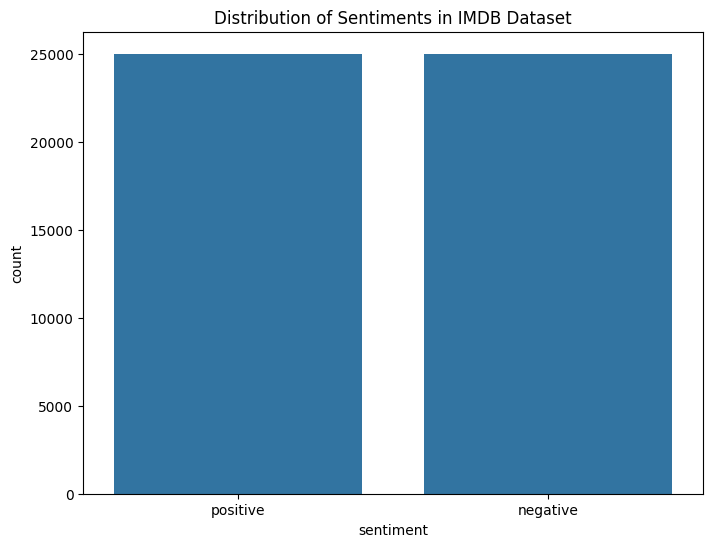


Dataset loaded successfully!

Sample positive review:
One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me abo...

Sample negative review:
Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, J...


In [22]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)

def load_imdb_dataset(filepath='C:/Users/Kone/Downloads/archive/IMDB Dataset.csv'):
    """Load the IMDB dataset and perform initial verification"""
    df = pd.read_csv(filepath)
    
    # Display basic information about the dataset
    print("Dataset Shape:", df.shape)
    print("\nDataset Info:")
    print(df.info())
    print("\nFirst few rows of the dataset:")
    print(df.head())
    print("\nMissing values in each column:")
    print(df.isnull().sum())
    print("\nSentiment distribution:")
    print(df['sentiment'].value_counts())
    
    # Create a distribution plot
    plt.figure(figsize=(8, 6))
    sns.countplot(x='sentiment', data=df)
    plt.title('Distribution of Sentiments in IMDB Dataset')
    plt.show()
    
    return df

# Load the dataset
df = load_imdb_dataset()
print("\nDataset loaded successfully!")

# Display sample reviews
print("\nSample positive review:")
print(df[df['sentiment'] == 'positive']['review'].iloc[0][:200] + "...")
print("\nSample negative review:")
print(df[df['sentiment'] == 'negative']['review'].iloc[0][:200] + "...")

Step 2: Data Preprocessing

In [23]:
def preprocess_data(df):
    """Preprocess the IMDB dataset"""
    # Encode sentiment labels (positive -> 1, negative -> 0)
    df['label'] = (df['sentiment'] == 'positive').astype(int)
    df = df[['review', 'label']]
    
    # Basic text cleaning
    df['review'] = df['review'].apply(lambda x: x.strip().lower())
    df = df[df['review'].str.len() > 0].reset_index(drop=True)
    
    # Split into training (80%), validation (10%), and test (10%) sets
    train_df, temp_df = train_test_split(
        df, test_size=0.2, random_state=42, stratify=df['label']
    )
    
    val_df, test_df = train_test_split(
        temp_df, test_size=0.5, random_state=42, stratify=temp_df['label']
    )
    
    # Reset indices
    train_df = train_df.reset_index(drop=True)
    val_df = val_df.reset_index(drop=True)
    test_df = test_df.reset_index(drop=True)
    
    print("\nDataset splits:")
    print(f"Training set: {len(train_df)} samples")
    print(f"Validation set: {len(val_df)} samples")
    print(f"Test set: {len(test_df)} samples")
    
    return train_df, val_df, test_df

# Apply preprocessing
train_df, val_df, test_df = preprocess_data(df)
print("\nPreprocessing completed successfully!")


Dataset splits:
Training set: 40000 samples
Validation set: 5000 samples
Test set: 5000 samples

Preprocessing completed successfully!


C:\Users\Kone\AppData\Local\Temp\ipykernel_17092\3489028217.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['review'] = df['review'].apply(lambda x: x.strip().lower())


Step 3: Model Selection and Tokenization

In [24]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset
import torch
from tqdm.auto import tqdm

# Constants
MODEL_NAME = "distilbert-base-uncased"
MAX_LENGTH = 256
BATCH_SIZE = 32

class IMDBDataset(Dataset):
    """Custom Dataset for IMDB reviews"""
    def __init__(self, reviews, labels, tokenizer, max_length):
        self.reviews = reviews
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.reviews)
    
    def __getitem__(self, idx):
        review = str(self.reviews[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer(
            review,
            add_special_tokens=True,
            max_length=self.max_length,
            truncation=True,            # As per requirements
            padding='max_length',       # As per requirements
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Initialize model and tokenizer
print(f"Loading model and tokenizer: {MODEL_NAME}")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2,
    return_dict=True
)
print("Model and tokenizer loaded successfully!")

# Create datasets
train_dataset = IMDBDataset(train_df['review'].values, train_df['label'].values, tokenizer, MAX_LENGTH)
val_dataset = IMDBDataset(val_df['review'].values, val_df['label'].values, tokenizer, MAX_LENGTH)
test_dataset = IMDBDataset(test_df['review'].values, test_df['label'].values, tokenizer, MAX_LENGTH)

print(f"\nDatasets created successfully!")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Loading model and tokenizer: distilbert-base-uncased


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model and tokenizer loaded successfully!

Datasets created successfully!
Training samples: 40000
Validation samples: 5000
Test samples: 5000


Step 4: Fine-Tune the Model 

In [25]:
from transformers import TrainingArguments, Trainer
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import os

def compute_metrics(eval_pred):
    """Compute metrics for evaluation"""
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='binary'
    )
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=2,                      # As per requirements
    per_device_train_batch_size=32,          # As per requirements (16 or 32)
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    evaluation_strategy="epoch",             # Evaluate at end of each epoch
    save_strategy="epoch",
    learning_rate=5e-5,                      # As per requirements
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="none"                         # Disable wandb reporting
)

# Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer
)

# Train the model
print("Starting model training...")
trainer.train()

# Evaluate and print final metrics
final_metrics = trainer.evaluate()
print("\nFinal Evaluation Metrics:")
print(f"Accuracy: {final_metrics['eval_accuracy']:.4f}")
print(f"Precision: {final_metrics['eval_precision']:.4f}")
print(f"Recall: {final_metrics['eval_recall']:.4f}")
print(f"F1 Score: {final_metrics['eval_f1']:.4f}")

# Save final model and metrics
trainer.save_model("./results")
metrics_path = os.path.join("./results", "training_metrics.txt")
with open(metrics_path, "w") as f:
    for key, value in final_metrics.items():
        f.write(f"{key}: {value}\n")
print(f"\nModel and metrics saved to ./results")

c:\Users\Kone\ftllm\yes\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\Kone\AppData\Local\Temp\ipykernel_17092\1383693292.py:42: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Starting model training...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.234600,0.217222,0.914200,0.902449,0.928800,0.915435
2,0.133800,0.212472,0.923200,0.919841,0.927200,0.923506



Final Evaluation Metrics:
Accuracy: 0.9232
Precision: 0.9198
Recall: 0.9272
F1 Score: 0.9235

Model and metrics saved to ./results


Step 5: Save and Upload the Model to Hugging Face

In [26]:
from huggingface_hub import notebook_login
import os

# 1. Save model and tokenizer locally
output_dir = "./final_model"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model and tokenizer locally...")
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
print(f"Model and tokenizer saved to {output_dir}")

# 2. Login to Hugging Face
print("\nPlease login to Hugging Face (a browser window will open)...")
notebook_login()

# 3. Push model to hub
repo_name = "Etwo02/imdb-sentiment-classifier"  # You can change this name
try:
    print(f"\nUploading model to Hugging Face Hub...")
    model.push_to_hub(repo_name)
    tokenizer.push_to_hub(repo_name)
    print(f"Model successfully uploaded to Hugging Face Hub!")
    print(f"You can find the model at: https://huggingface.co/{repo_name}")
    
except Exception as e:
    print(f"Error uploading model: {str(e)}")
    print("Please make sure you're logged in and have the correct permissions")

Saving model and tokenizer locally...
Model and tokenizer saved to ./final_model

Please login to Hugging Face (a browser window will open)...



Uploading model to Hugging Face Hub...


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

c:\Users\Kone\ftllm\yes\Lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Kone\.cache\huggingface\hub\models--Etwo02--imdb-sentiment-classifier. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
No files have been modified since last commit. Skipping to prevent empty commit.


Model successfully uploaded to Hugging Face Hub!
You can find the model at: https://huggingface.co/Etwo02/imdb-sentiment-classifier


4. Link to model https://huggingface.co/Etwo02/imdb-sentiment-classifier

**Part 2: API Development and Testing**

Step 6: Set Up the Backend API 

In [ ]:
# main.py
# main.py
from fastapi import FastAPI, HTTPException
from pydantic import BaseModel
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
import torch.nn.functional as F
from typing import Literal
import os
from dotenv import load_dotenv
import httpx
import json
import nest_asyncio
import uvicorn
from fastapi.middleware.cors import CORSMiddleware

# Apply nest_asyncio to allow running async code in Jupyter
nest_asyncio.apply()

# Load environment variables
load_dotenv()

app = FastAPI(
    title="Sentiment Analysis API",
    description="API for analyzing sentiment using custom DistilBERT and Llama 3 models",
    version="1.0.0"
)

app.add_middleware(
    CORSMiddleware,
    allow_origins=["*"],
    allow_credentials=True,
    allow_methods=["*"],
    allow_headers=["*"],
)


# Model paths and configs
MODEL_PATH = "./final_model"  # Update with your model path
TOKENIZER_PATH = "./tokenizer_config"  # Update with your tokenizer path
MAX_LENGTH = 256

# Initialize custom model and tokenizer
custom_tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_PATH)
custom_model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH)
custom_model.eval()

# Groq API configuration
GROQ_API_KEY = os.getenv("GROQ_API_KEY")
GROQ_API_URL = "https://api.groq.com/openai/v1/chat/completions" 

class SentimentRequest(BaseModel):
    text: str
    model: Literal["custom", "llama"]

class SentimentResponse(BaseModel):
    sentiment: str
    confidence: float

def analyze_with_custom_model(text: str) -> tuple[str, float]:
    """
    Analyze sentiment using the custom fine-tuned model
    """
    try:
        # Tokenize input
        inputs = custom_tokenizer(
            text,
            truncation=True,
            max_length=MAX_LENGTH,
            padding=True,
            return_tensors="pt"
        )

        # Get model prediction
        with torch.no_grad():
            outputs = custom_model(**inputs)
            probabilities = F.softmax(outputs.logits, dim=1)
            prediction = torch.argmax(probabilities, dim=1)
            confidence = torch.max(probabilities).item()

        # Convert prediction to sentiment
        sentiment = "positive" if prediction.item() == 1 else "negative"
        
        return sentiment, confidence

    except Exception as e:
        raise HTTPException(status_code=500, detail=f"Custom model error: {str(e)}")

async def analyze_with_llama(text: str) -> tuple[str, float]:
    """
    Analyze sentiment using Llama 3 via Groq API
    """
    try:
        headers = {
            "Authorization": f"Bearer {GROQ_API_KEY}",
            "Content-Type": "application/json"
        }
        
        prompt = f"""Analyze the sentiment of the following text and respond with a JSON object containing two fields:
        1. "sentiment": either "positive" or "negative"
        2. "confidence": a float between 0 and 1 indicating your confidence

        Text: "{text}"

        Respond only with the JSON object."""

        payload = {
            "model": "llama3-70b-8192",  # Updated model name
            "messages": [
                {"role": "system", "content": "You are a sentiment analysis expert."},
                {"role": "user", "content": prompt}
            ],
            "temperature": 0.1,
            "max_tokens": 100
        }

        async with httpx.AsyncClient() as client:
            response = await client.post(GROQ_API_URL, headers=headers, json=payload)
            response.raise_for_status()
            
            # Parse the response
            result = response.json()
            content = result['choices'][0]['message']['content']
            parsed_result = json.loads(content)
            
            return parsed_result["sentiment"], float(parsed_result["confidence"])

    except Exception as e:
        raise HTTPException(status_code=500, detail=f"Llama model error: {str(e)}")

@app.post("/analyze/", response_model=SentimentResponse)
async def analyze_sentiment(request: SentimentRequest):
    """
    Analyze the sentiment of input text using either custom or Llama model
    """
    try:
        if request.model == "custom":
            sentiment, confidence = analyze_with_custom_model(request.text)
        else:  # llama
            sentiment, confidence = await analyze_with_llama(request.text)

        return SentimentResponse(
            sentiment=sentiment,
            confidence=confidence
        )

    except Exception as e:
        raise HTTPException(status_code=500, detail=str(e))

def run_server():
    """Function to run the server"""
    config = uvicorn.Config(app, host="0.0.0.0", port=8000, log_level="info")
    server = uvicorn.Server(config)
    server.run()

# For Jupyter Notebook
def start_server():
    """Function to start the server in a notebook"""
    import asyncio
    config = uvicorn.Config(app, host="0.0.0.0", port=8000, log_level="info")
    server = uvicorn.Server(config)
    asyncio.create_task(server.serve())
    return "Server started"

if __name__ == "__main__":
    run_server()

INFO:     Started server process [17092]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO:     127.0.0.1:53116 - "OPTIONS /analyze/ HTTP/1.1" 200 OK
INFO:     127.0.0.1:53116 - "POST /analyze/ HTTP/1.1" 200 OK
INFO:     127.0.0.1:53218 - "POST /analyze/ HTTP/1.1" 200 OK
INFO:     127.0.0.1:53220 - "POST /analyze/ HTTP/1.1" 200 OK
INFO:     127.0.0.1:53220 - "POST /analyze/ HTTP/1.1" 200 OK
INFO:     127.0.0.1:53220 - "POST /analyze/ HTTP/1.1" 200 OK
INFO:     127.0.0.1:53220 - "POST /analyze/ HTTP/1.1" 200 OK
INFO:     127.0.0.1:53258 - "POST /analyze/ HTTP/1.1" 200 OK
INFO:     127.0.0.1:53258 - "POST /analyze/ HTTP/1.1" 200 OK
INFO:     127.0.0.1:53258 - "POST /analyze/ HTTP/1.1" 200 OK
INFO:     127.0.0.1:53258 - "POST /analyze/ HTTP/1.1" 200 OK
INFO:     127.0.0.1:53258 - "POST /analyze/ HTTP/1.1" 200 OK
INFO:     127.0.0.1:53260 - "POST /analyze/ HTTP/1.1" 200 OK
INFO:     127.0.0.1:53274 - "POST /analyze/ HTTP/1.1" 200 OK
INFO:     127.0.0.1:53274 - "POST /analyze/ HTTP/1.1" 200 OK
INFO:     127.0.0.1:53274 - "POST /analyze/ HTTP/1.1" 200 OK
INFO:     127.0.0.1:5

Step 7: Load Models

In [30]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from groq import Groq
import os
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

def load_custom_model(model_id):
    """
    Load the fine-tuned model from Hugging Face
    
    Args:
        model_id (str): Hugging Face model ID (e.g., 'your-username/your-model-name')
    
    Returns:
        tuple: (model, tokenizer) if successful, (None, None) if failed
    """
    try:
        # Load tokenizer and model from Hugging Face
        tokenizer = AutoTokenizer.from_pretrained(model_id)
        model = AutoModelForSequenceClassification.from_pretrained(model_id)
        
        # Set model to evaluation mode
        model.eval()
        
        print("Successfully loaded custom model from Hugging Face")
        return model, tokenizer
        
    except Exception as e:
        print(f"Error loading custom model: {str(e)}")
        return None, None

def initialize_groq_client():
    """
    Initialize Groq client for accessing Llama 3
    
    Returns:
        Groq: Initialized Groq client if successful, None if failed
    """
    try:
        client = Groq(
            api_key=os.environ.get("GROQ_API_KEY"),
        )
        print("Successfully initialized Groq client")
        return client
        
    except Exception as e:
        print(f"Error initializing Groq client: {str(e)}")
        return None

if __name__ == "__main__":
    # Load custom model from Hugging Face
    model_id = "Etwo02/imdb-sentiment-classifier"  # Replace with your model ID
    model, tokenizer = load_custom_model(model_id)
    
    # Initialize Groq client for Llama 3
    groq_client = initialize_groq_client()
    
    # Test Llama 3 access if client initialization was successful
    if groq_client:
        try:
            response = groq_client.chat.completions.create(
                messages=[
                    {
                        "role": "user",
                        "content": "Test message"
                    }
                ],
                model="llama-3.3-70b-versatile",
            )
            print("Successfully accessed Llama 3 model")
            
        except Exception as e:
            print(f"Error accessing Llama 3 model: {str(e)}")

tokenizer_config.json:   0%|          | 0.00/1.28k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/640 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Successfully loaded custom model from Hugging Face
Successfully initialized Groq client
Successfully accessed Llama 3 model


Step 8: Test the API Locally

![alt text](postman.png "Postman Test")


Curl: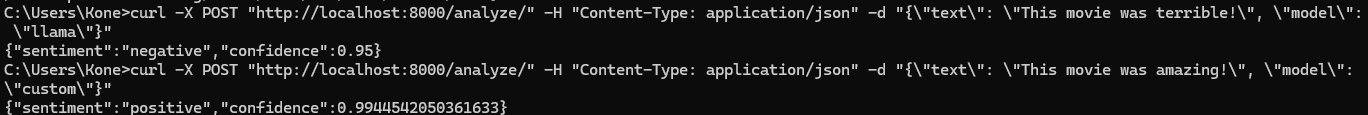


Python requests:



![alt text](requests.png "Python requests")


Step 9: Define the Llama 3 Prompt


You are a precise sentiment analysis expert. Analyze the sentiment of the following text and provide your analysis in this specific format:
{
    "sentiment": "<positive/negative>",
    "confidence": <0.0-1.0>
}

Text to analyze: "<input_text>"

Base your analysis on:
- Overall emotional tone
- Use of descriptive words
- Context and implications
- Intensity of expression

Ensure your response is ONLY the JSON object with no additional text.

Step 10: Test with Both Models (already tested in step 8)


![alt text](requests.png "Python requests")


Works as expected, sentiment and confidence are returned.


Step 11: React UI Design


![alt text](uidesign.png "UI design")


In [ ]:
// SentimentAnalyzer.jsx (only the analysis component here - rest in git repo)
import { useState } from 'react';
import './SentimentAnalyzer.css';

function SentimentAnalyzer() {
  const [text, setText] = useState('');
  const [model, setModel] = useState('custom');
  const [result, setResult] = useState(null);
  const [isLoading, setIsLoading] = useState(false);
  const [error, setError] = useState(null);

  const analyzeSentiment = async () => {
    if (!text.trim()) return;

    setIsLoading(true);
    setError(null);
    try {
      const response = await fetch('http://localhost:8000/analyze/', {
        method: 'POST',
        headers: {
          'Content-Type': 'application/json',
          'Accept': 'application/json',
        },
        body: JSON.stringify({
          text,
          model,
        }),
      });

      if (!response.ok) {
        const errorData = await response.json();
        throw new Error(errorData.detail || 'Failed to analyze sentiment');
      }

      const data = await response.json();
      setResult(data);
    } catch (error) {
      console.error('Error:', error);
      setError(error.message || 'Failed to analyze sentiment. Please try again.');
      setResult(null);
    } finally {
      setIsLoading(false);
    }
  };

  const clearResults = () => {
    setResult(null);
    setText('');
    setError(null);
  };

  return (
    <div className="analyzer-container">
      <div className="analyzer-card">
        <h2 className="analyzer-title">Sentiment Analysis</h2>
        
        <div className="input-group">
          <label htmlFor="text-input">Enter your text:</label>
          <textarea
            id="text-input"
            value={text}
            onChange={(e) => setText(e.target.value)}
            placeholder="Type or paste your text here..."
          />
        </div>

        <div className="input-group">
          <label htmlFor="model-select">Select Model:</label>
          <select
            id="model-select"
            value={model}
            onChange={(e) => setModel(e.target.value)}
          >
            <option value="custom">Custom Model</option>
            <option value="llama">Llama 3</option>
          </select>
        </div>

        <button
          onClick={analyzeSentiment}
          disabled={!text.trim() || isLoading}
          className="analyze-button"
        >
          {isLoading ? 'Analyzing...' : 'Analyze Sentiment'}
        </button>

        {error && (
          <div className="error-message">
            {error}
          </div>
        )}

        {result && !error && (
          <div className="results-container">
            <h3>Results</h3>
            <div className="result-item">
              <span>Sentiment:</span>
              <span className={`sentiment-${result.sentiment}`}>
                {result.sentiment.charAt(0).toUpperCase() + result.sentiment.slice(1)}
              </span>
            </div>
            <div className="result-item">
              <span>Confidence:</span>
              <span className="confidence">
                {(result.confidence * 100).toFixed(1)}%
              </span>
            </div>
            <button
              onClick={clearResults}
              className="clear-button"
            >
              Clear Analysis
            </button>
          </div>
        )}
      </div>
    </div>
  );
}

export default SentimentAnalyzer;

Step 13: Record a YouTube Demo Video

https://www.youtube.com/watch?v=9K1vyvQ0gU0